In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
from skimage.transform import rotate
import pims, sys
from pathlib import Path
import trackpy as tp
import pandas as pd

In [5]:
# This is to crop the stack, so that we only have the red channel
base_path = Path(r'C:\Users\jrosk\Dropbox\Warwick\TIRF\February_2023\22-02-2023\Untreated_Sample')
file_path = base_path.joinpath(r'Slides\Slide_1\22-Feb-23_tirf-17.tif')

axis_path = Path('splines\spline_0.txt')
# Create a SimpleSpline object containing the filament axis
axis_0 = SimpleSpline.from_csv(axis_path, 0.01)

@pims.pipeline
def crop_image(frame):
    return rotate(frame,90, preserve_range=True, resize=True)[428:]

# Both channels
full_roi_stack_0 = pims.open(file_path.as_posix())

# Apply pipeline
images_0 = crop_image(full_roi_stack_0)


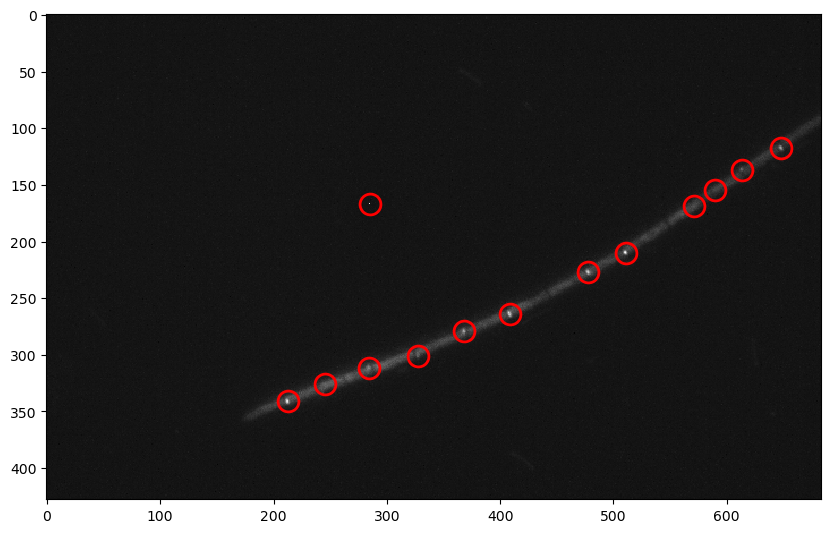

<Axes: >

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
img_test = images_0[200] 
f = tp.locate(img_test,  diameter=5, minmass=150, separation=20, noise_size=1.0)
tp.annotate(f, img_test)

> 5. Batch process the stack, link particles into trajectories, filter short trajectories

In [7]:
# Version one file
all_particles = tp.batch(images_0,diameter=5, minmass=150, separation=20, noise_size=1.0)

Frame 1825: 13 features


In [11]:
all_linked = tp.link(all_particles, search_range=1, memory=2)
all_linked_filtered = tp.filter_stubs(all_linked, 50)

Frame 1825: 13 trajectories present.


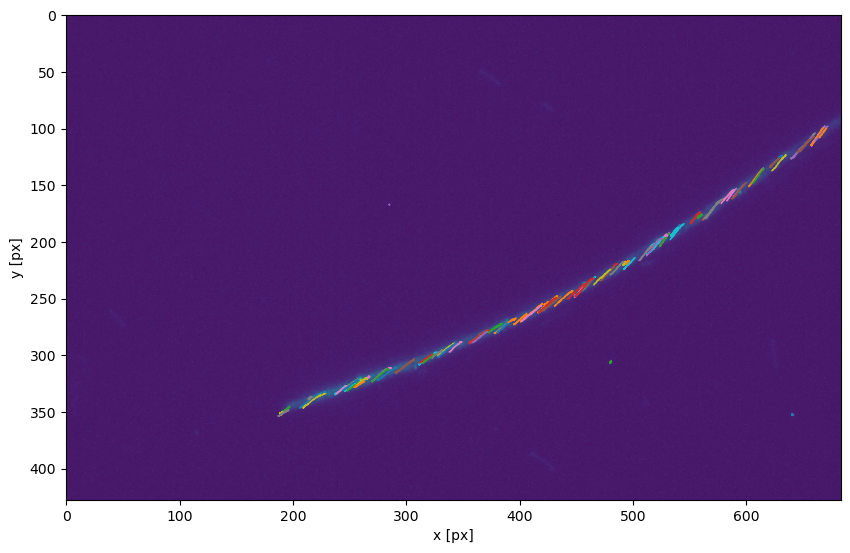

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [13]:
# Inspect results
fig, ax = plt.subplots(1,1, figsize = (10,10))
plt.imshow(images_0[0])
#plt.ylim(500,200)
tp.plot_traj(all_linked_filtered)

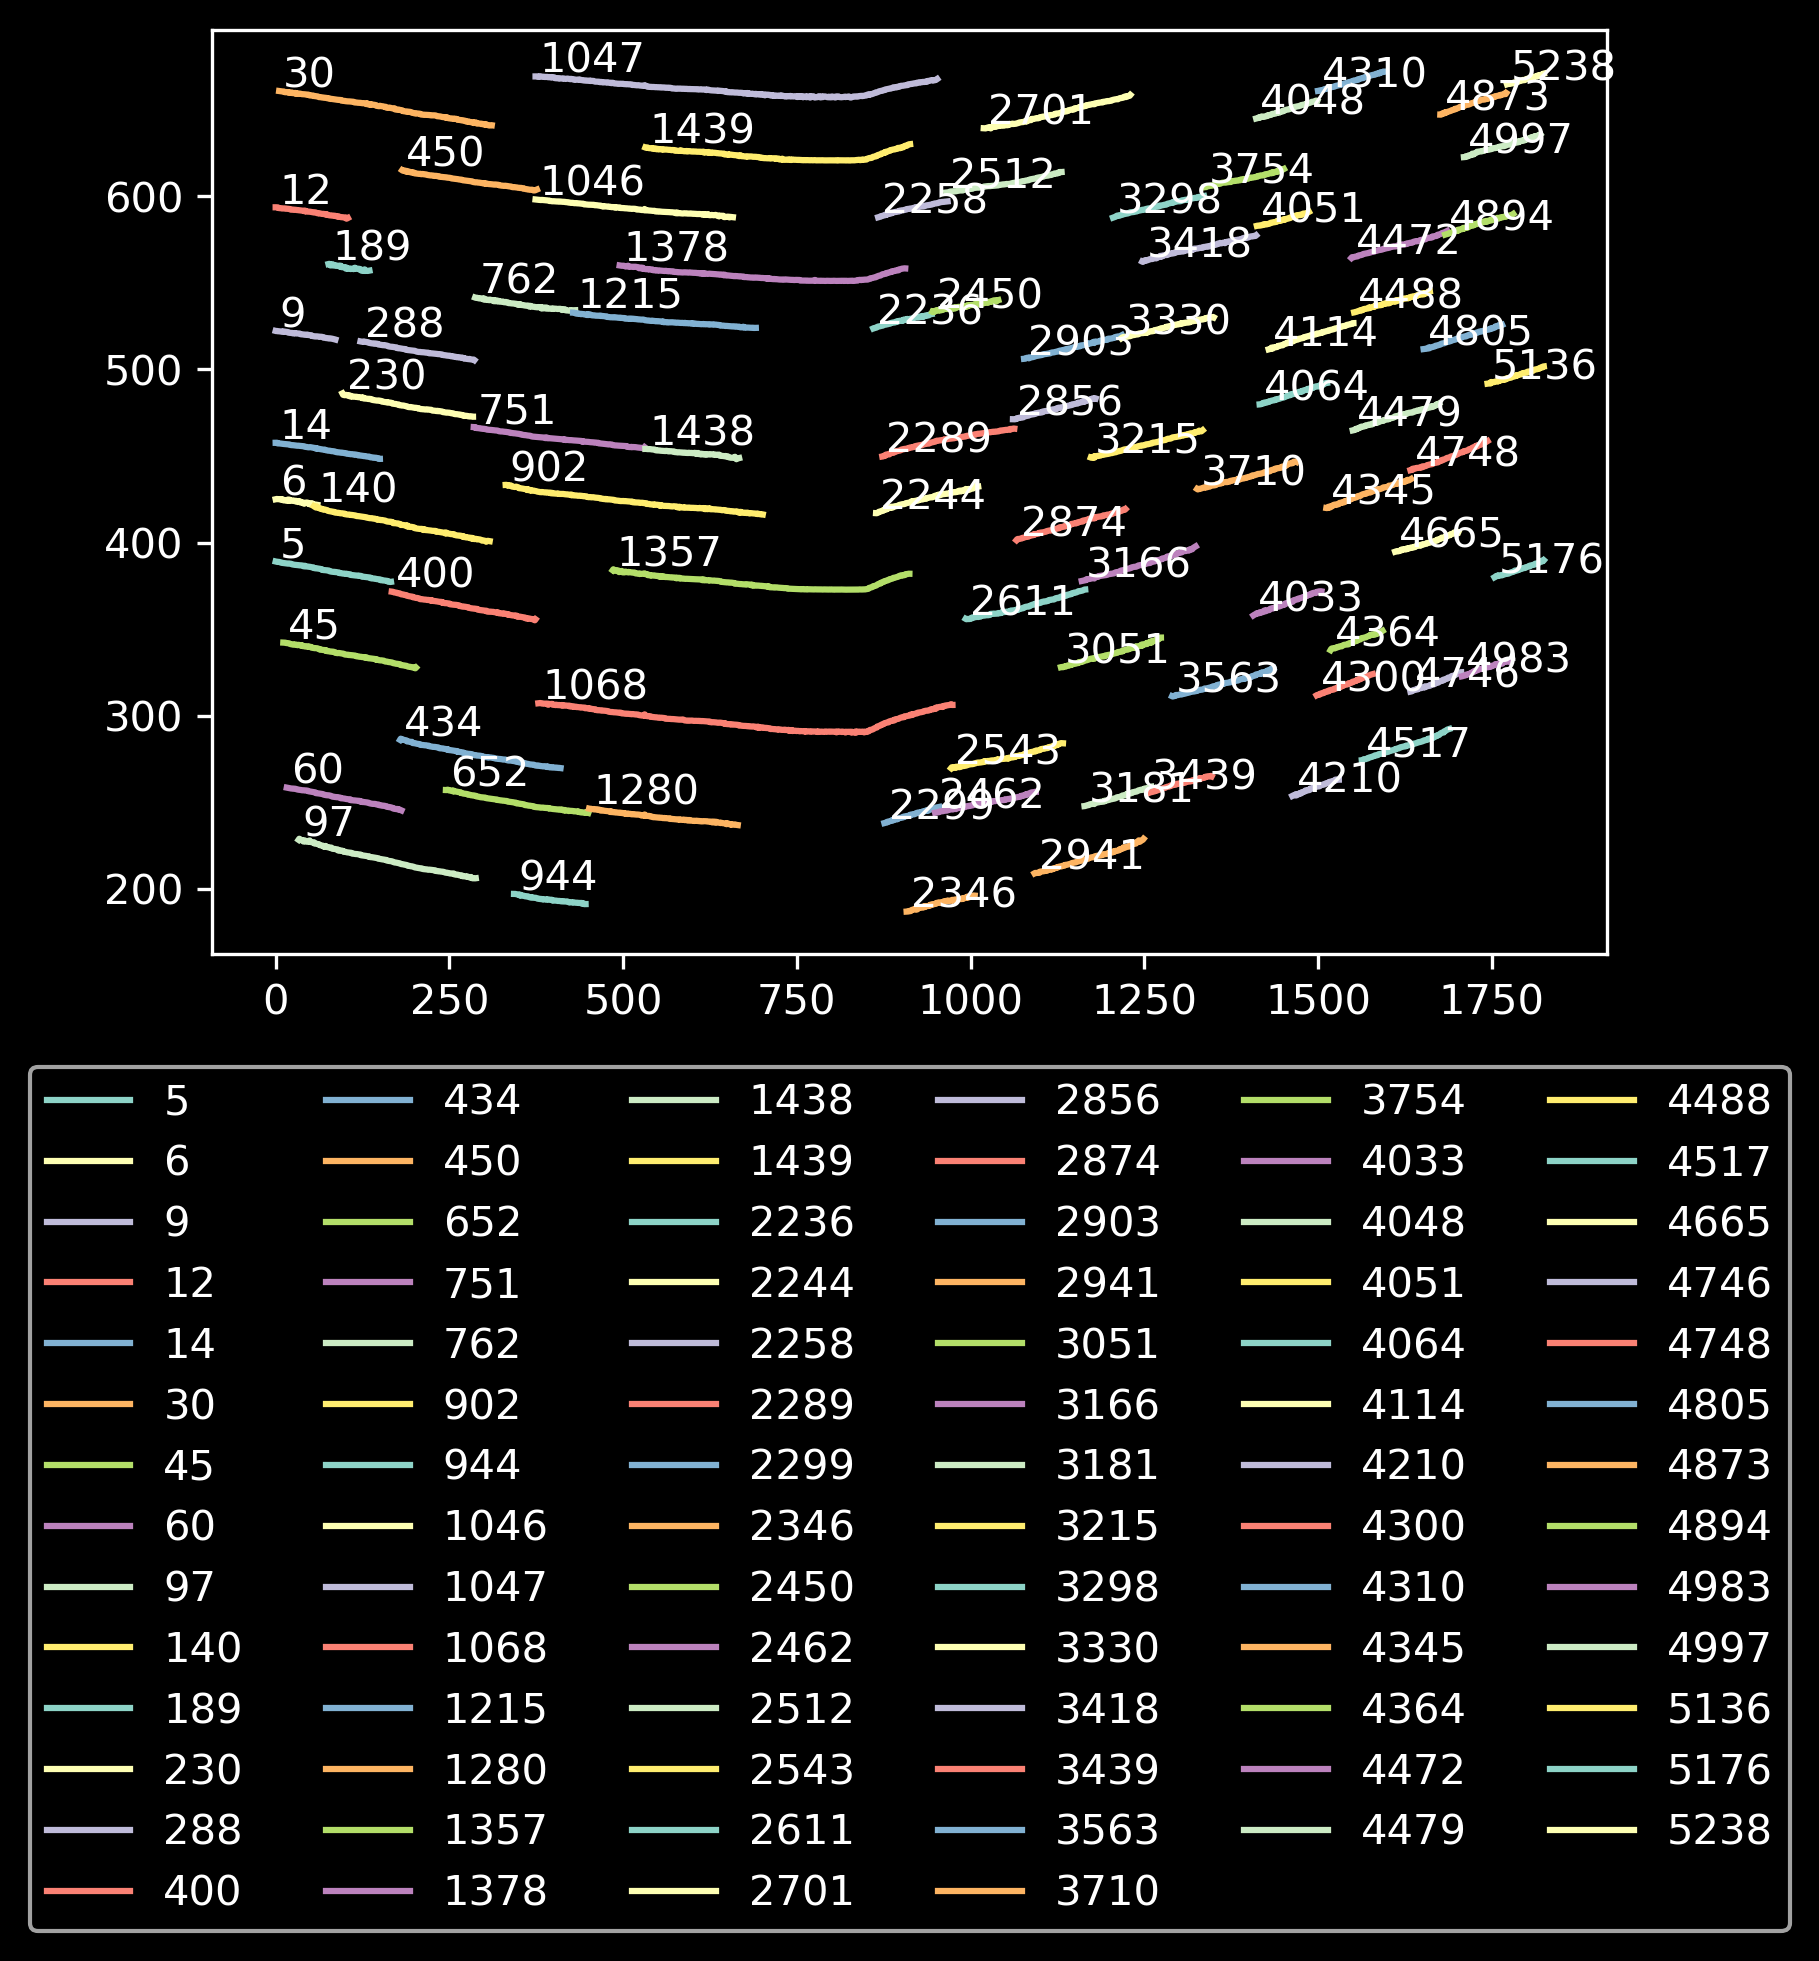

In [19]:
# there will be some artefacts, these don't really change in x coord
all_linked_filtered= all_linked_filtered.groupby('particle').filter(lambda group: group['x'].std() >= 1)


particles = all_linked_filtered['particle'].unique()

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1, figsize = (6,4), dpi=300)
    for particle in particles:
        data_for_particle = all_linked_filtered[(all_linked_filtered['particle'].isin(particles)) 
                                                & (all_linked_filtered['particle']==particle)]
        ax.plot(data_for_particle['frame'].values, data_for_particle['x'].values,'-', label=f'{particle}')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=6)
        ax.annotate(f'{particle}', xy=(data_for_particle['frame'].values[0], data_for_particle['x'].values[0]), xytext=(1, 1),textcoords='offset points')
    #ax.set_ylim(258,263)
    #ax.set_xlim(1800,2500)
        

In [18]:
# merge 1047,1440,2125
all_linked_filtered['particle'] = all_linked_filtered['particle'].replace([1440, 2125], 1047)


In [20]:
all_linked_filtered['experiment'] = file_path.stem
all_linked_filtered = all_linked_filtered.reset_index(drop=True)
all_linked_filtered.to_csv(f'tracks/{file_path.stem}.csv', index=False)